# 04 - How to do FWI with Dask


In [1]:
import dask
from distributed import Client

from scipy import optimize

from devito import Function, clear_cache
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Model

from examples.seismic import demo_model
from examples.seismic import RickerSource, Receiver

import numpy as np

class fgtype:
    def __init__(self, f, g):
        self.f = f
        self.g = g
    
    def __add__(self, other):
        f = self.f + other.f
        g = self.g + other.g
        
        return fgtype(f, g)
    
    def __radd__(self, other):
        if other == 0:
            return self
        else:
            return self.__add__(other)

# Define true and initial model
def get_grid():
    shape = (101, 101)  # Number of grid point (nx, nz)
    spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
    origin = (0., 0.)  # Need origin to define relative source and receiver locations

    return shape, spacing, origin

def get_true_model():
    shape, spacing, origin = get_grid()
    return demo_model('circle-isotropic', vp=3.0, vp_background=2.5, 
                      origin=origin, shape=shape, spacing=spacing, nbpml=40)

def get_initial_model():
    shape, spacing, origin = get_grid()

    return demo_model('circle-isotropic', vp=2.5, vp_background=2.5, 
                      origin=origin, shape=shape, spacing=spacing, nbpml=40)

def dump_model(param, model):
    np.save(param['model'], model.astype(np.float32))

def load_model(param):
    return np.load(param['model'])

def get_current_model(param):
    model = get_initial_model()
    model.m.data[:] = np.reshape(load_model(param), model.m.data.shape)
    return model

# Define acquisition geometry: source
def get_data(param):
    """ Returns source and receiver data for shot i.
    """
    true_model = get_true_model()
    dt = true_model.critical_dt  # Time step from model grid spacing

    # Set up src
    nt = int(1 + (param['tn']-param['t0']) / dt)  # Discrete time axis length

    src = RickerSource(name='src', ndim=2, f0=param['f0'],
                       time=np.linspace(param['t0'], param['tn'], nt))
    src.coordinates.data[0, :] = [30, param['shot_id']*1000./(param['nshots']-1)]

    # Set up rec
    nreceivers = 101  # Number of receiver locations per shot
    rec = Receiver(name='rec', npoint=nreceivers, ntime=nt, ndim=2)
    rec.coordinates.data[:, 1] = np.linspace(0, true_model.domain_size[0], num=nreceivers)
    rec.coordinates.data[:, 0] = 980. # 20m from the right end

    # Set up solver - using model_in so that we have the same dt
    solver = AcousticWaveSolver(true_model, src, rec, space_order=4)

    # Generate synthetic receiver data from true model
    true_d, _, _ = solver.forward(src=src, m=true_model.m)

    return src, true_d, nt, solver

# Create FWI gradient kernel 
def fwi_gradient_i(work):
    clear_cache()
    
    param, shot_id = work
    param['shot_id'] = shot_id

    model0 = get_current_model(param)
    src, rec, nt, solver = get_data(param)
    
    # Create symbols to hold the gradient and residual
    grad = Function(name="grad", grid=model0.grid)
    residual = Receiver(name='rec', ntime=nt, coordinates=rec.coordinates.data)
    
    # Compute simulated data and full forward wavefield u0
    d, u0, _ = solver.forward(src=src, m=model0.m, save=True)
        
    # Compute gradient from data residual and update objective function 
    residual.data[:] = d.data[:] - rec.data[:]
    f = .5*np.linalg.norm(residual.data.flatten())**2
    
    solver.gradient(rec=residual, u=u0, m=model0.m, grad=grad)
    
    # Take a copy of the gradient as async-comms can result in the
    # solution being erased (via clear_cache) before reduction is
    # performed.
    g = np.array(grad.data[:])
    
    g[0:25,:] = 0.
    g[-25:,:] = 0.

    return fgtype(f, g)

def fwi_gradient(model, parameters):
    param['model'] = "model_0.npy"
    dump_model(param, model)

    client = Client()
    
    work = [(param, i) for i in range(parameters['nshots'])]
    fgi = client.map(fwi_gradient_i, work)
    fg = client.submit(sum, fgi).result()
    client.close()
    
    return fg.f, fg.g.flatten().astype(np.float64)

def fwi(model, param):
    result = optimize.minimize(fwi_gradient, model.m.data.flatten().astype(np.float64), args=(param, ),
                method='L-BFGS-B', jac=True, bounds=tuple((0.08, 0.25) for i in range(model.m.data.flatten().size)),
                options={'ftol':0.5, 'maxiter':100, 'disp':True})

    return result

In [2]:
if __name__ == '__main__':

    # Set up inversion parameters. We need to make sure that we
    # broadcast the model as a numpy array - otherwise dask doesn't
    # recognise when it has changed and won't re-broadcast.
    param = {'t0':0.,
             'tn':1000.,  # Simulation last 1 second (1000 ms)
             'f0':0.010,  # Source peak frequency is 10Hz (0.010 kHz)
             'nshots':11} # Number of shots to create gradient from

    model0 = get_initial_model()
    result = fwi(model0, param)

In [6]:
print(result)

      fun: 1159.7408644181496
 hess_inv: <32761x32761 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.,  0., ...,  0.,  0.,  0.])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 7
      nit: 4
   status: 0
  success: True
        x: array([ 0.16,  0.16,  0.16, ...,  0.16,  0.16,  0.16])


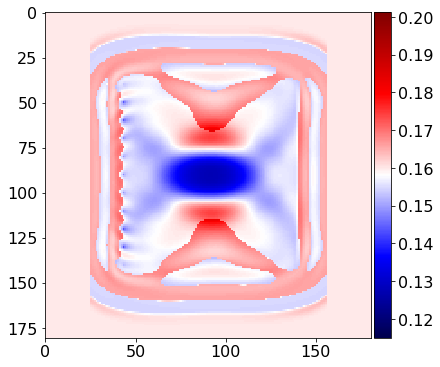

In [7]:
# Plot FWI gradient and model update
from examples.seismic import plot_image

# Show what the update does to the model
plot_image(result.x.reshape(181, 181), cmap="seismic")